In [1]:
import numpy as np
import pygame

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from util import GridCell, make_filter, plot_agreement_sum, update_grid

pygame 2.2.0 (SDL 2.26.5, Python 3.11.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
kernel_size = 31

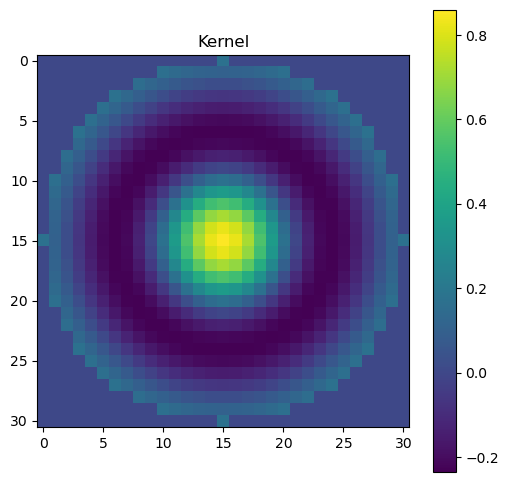

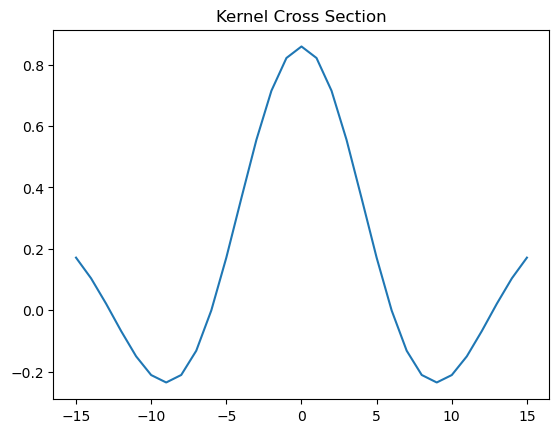

In [4]:
# Instantiate the model
model = GridCell(kernel_size).to(device)

# Manually set the weights and biases of the conv_stationary layer
with torch.no_grad():
    weights = make_filter(kernel_size, 0, 0).to(device)
    model.conv_stationary.weight = nn.Parameter(weights)

plt.figure(figsize=(6, 6))
plt.imshow(model.conv_stationary.weight[0, 0].cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title("Kernel")
plt.show()

plt.plot(np.linspace(-15,15, 31), weights[0,0,kernel_size//2].cpu().detach().numpy())
plt.title("Kernel Cross Section");

In [5]:
portion_update = 1
random_factor = 0.5

iters_per_frame = 10
move_per_frame = 1

half_kernel = kernel_size // 2

grid_size = 100
center = grid_size // 2

In [6]:
grids = torch.rand(1, 1, grid_size, grid_size).to(device) * 0.5

# Allow user to choose the number of points to be masked
portion_masked = 1/3
num_masked_points = int(grid_size**2 * portion_masked)  # You can change this value as needed

# Generate random positions for the masked points
masked_positions = torch.randint(0, grid_size, (num_masked_points, 2))

# Create the mask with the specified number of masked points
mask = torch.zeros((grid_size, grid_size), dtype=torch.bool).to(device)

for pos in masked_positions:
    mask[pos[0], pos[1]] = True

### Here power is initialized to 1.5, use R and F to change the power while running the program

~1 - Square Lattice

~1.3 - Triangular Lattice

~1.5 - Semi Collapsed (try matching the input point velocity with the global velocity)

~1.6 - Collapsed

In [7]:
power = 1.5
should_input = True
input_points = np.zeros((1, 2))

In [8]:
running = True
clock = pygame.time.Clock()

sums = []
is_agreed = []

# Initialize pygame
pygame.init()
window_size = (1000, 1000)
screen = pygame.display.set_mode(window_size)
pygame.display.set_caption("Grid Evolution")
font = pygame.font.SysFont(None, 36)

while running:
    # Check for close window event and should_input change
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False
        if event.type == pygame.KEYDOWN:
            if event.key == pygame.K_ESCAPE:
                running = False
            elif event.key == pygame.K_SPACE:
                should_input = not should_input
    
    # Get the keys that are currently pressed
    keys = pygame.key.get_pressed()
    
    # Update the velocity based on the keys pressed
    velocity_input = np.zeros(2)
    if keys[pygame.K_a]:
        velocity_input[1] -= 1
    if keys[pygame.K_d]:
        velocity_input[1] += 1
    if keys[pygame.K_w]:
        velocity_input[0] -= 1
    if keys[pygame.K_s]:
        velocity_input[0] += 1
    
    # Update the input point based on the keys pressed
    delta_input = np.zeros(2)
    if keys[pygame.K_LEFT]:
        delta_input[1] -= 1
    elif keys[pygame.K_RIGHT]:
        delta_input[1] += 1
    if keys[pygame.K_UP]:
        delta_input[0] -= 1
    elif keys[pygame.K_DOWN]:
        delta_input[0] += 1
        
    # Update the power based on the keys pressed
    if keys[pygame.K_r]:
        power += 0.01
    if keys[pygame.K_f]:
        power -= 0.01

    # Normalize the velocity and input point update
    vel_len = (velocity_input[0]**2 + velocity_input[1]**2)**0.5
    velocity = np.zeros(2)
    if vel_len != 0:
        velocity_input /= vel_len
        
        # set the velocity taking into account the move_per_frame, iters_per_frame, and portion_masked 
        # multiply by a small factor to make it more responsive (1.2)
        velocity = velocity_input * move_per_frame / iters_per_frame / portion_masked * 1.15
           
    input_len = (delta_input[0]**2 + delta_input[1]**2)**0.5
    if input_len != 0:
        delta_input /= input_len
        input_points[0] += delta_input * move_per_frame
        
    
    # Create the direction kernel based on the velocity
    direction_kernel = make_filter(kernel_size, velocity[1], velocity[0]).to(device)
    
    # Update the grid
    grids, current_sum = update_grid(grids, model, mask, direction_kernel, should_input, input_points, power, iters_per_frame, random_factor, device)
    
    # Check if the input and velocity are in agreement
    if np.array_equal(delta_input, velocity_input):
        is_agreed.append(True)
    else:
        is_agreed.append(False)
    
    sums.append(current_sum)
    
    
    # Render the grid using pygame
    grid_np = grids[0, 0].cpu().detach().numpy()
    scaled_grid = (grid_np * 255).astype(np.uint8)
    rgb_grid = np.stack((scaled_grid,) * 3, axis=-1)
    rgb_grid[:, :, 0] = (rgb_grid[:, :, 0].astype(np.float32) * 0.5).astype(np.uint8)

    surface = pygame.surfarray.make_surface(rgb_grid)
    surface = pygame.transform.scale(surface, window_size)
    screen.blit(surface, (0, 0))

    # Instructional text
    text_surface = font.render("Arrows/Space: input, WASD: global velocity, R/F: power", True, (255, 100, 100))
    screen.blit(text_surface, (10, 10))
    
    # Render the text
    text_surface = font.render(f"Power: {power:.2f}, Current Sum: {current_sum:.2f}", True, (255, 255, 255))
    screen.blit(text_surface, (10, 50))
    
    # Draw arrows for delta_input and velocity
    arrow_start_pos = (window_size[0] - window_size[0] // 8, window_size[1] // 8)
    arrow_end_pos_delta = (arrow_start_pos[0] + int(delta_input[1] * 80), arrow_start_pos[1] + int(delta_input[0] * 80))
    arrow_end_pos_velocity = (arrow_start_pos[0] + int(velocity_input[1] * 80), arrow_start_pos[1] + int(velocity_input[0] * 80))
    
    pygame.draw.circle(screen, (240, 240, 240), arrow_start_pos, 80)
    pygame.draw.line(screen, (255, 0, 0), arrow_start_pos, arrow_end_pos_delta,  10)
    pygame.draw.line(screen, (0, 255, 0), arrow_start_pos, arrow_end_pos_velocity, 5)
    
    clock.tick(30)  # Limit to 30 frames per second
    
    # Render the FPS
    fps = clock.get_fps()
    text_surface = font.render(f"FPS: {clock.get_fps():.2f}", True, (255, 255, 255))
    screen.blit(text_surface, (10, 90))

    pygame.display.flip()
pygame.quit()


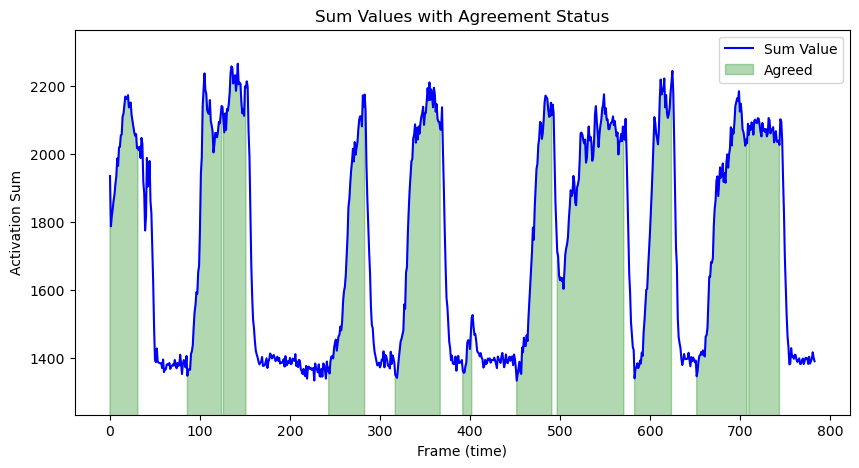

In [9]:
plot_agreement_sum(is_agreed, sums)